Start this on the zedboard first
```bash
$ sudo python3 litex_server.py --devmem --devmem-offset 0x40000000
```

In [1]:
%pylab notebook
from struct import pack, unpack
from time import sleep
import sys
sys.path.append("../..")
from common import *
from scope_app import autoBitslip, autoIdelay, getSamples

Populating the interactive namespace from numpy and matplotlib


# Setup SPI, reset and dump LTC2175 registers

In [2]:
r = conLitexServer('../build/csr.csv')
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")

Connected to Port 1234
LTC2175 demonstrator 2019-10-24 01:20:28
f_sample: 117.600594 MHz


In [430]:
ltc_spi = LTC_SPI(r)
for i in range(5):
    print("{:2x}: {:02x}".format(i, ltc_spi.get_ltc_reg(i)))

ltc_spi.set_ltc_reg(0, 0x80)   # Software reset
# ltc_spi.set_ltc_reg(1, 0x10)   # Sleep mode
# ltc_spi.set_ltc_reg(1, 0x00)   # Waky waky

ltc_spi.setTp(1)
autoBitslip(r)
autoIdelay(r)

Connected to Port 1234
LTC2175 demonstrator 2019-10-23 00:15:03
f_sample: 125.000628 MHz
 0: 00
 1: 20
 2: 00
 3: 00
 4: 00
autoBitslip(): aligned after 2
autoIdelay(): min = 5, mean = 12, max = 19 idelays


# Play with bitslip / idelay parameters

### show status

In [219]:
def print_frm():
    idel = r.regs.lvds_idelay_value.read()
    v = r.regs.lvds_frame_peek.read()
    print("ID: {:}  F: {:08b}".format(idel, v))
    for i in range(4):
        v = getattr(r.regs, 'lvds_data_peek{:}'.format(i)).read()
        print("{:}: {:016b}".format(i, v))
ltc_spi.setTp(1)
print_frm()

NameError: name 'ltc_spi' is not defined

### bitslip until we get 0xF0 on frame_peek

In [ ]:
r.regs.lvds_bitslip_csr.write(1)
print_frm()

### IDELAY adjustments to find the eye limits

In [ ]:
r.regs.lvds_idelay_inc.write(1)
print_frm()

In [ ]:
r.regs.lvds_idelay_dec.write(1)
print_frm()

do a bitslip until we get 0x0F

### map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [276]:
for ch in range(4):
    print("Channel {:d}".format(ch))
    for i in range(14):
        tpValue = 1 << i
        ltc_spi.setTp(tpValue)
        rVal = getattr(r.regs, 'lvds_data_peek{:d}'.format(ch)).read()
        print("{:016b} {:016b}".format(tpValue, rVal))    

Channel 0
0000000000000001 0000000000000001
0000000000000010 0000000000000010
0000000000000100 0000000000000100
0000000000001000 0000000000001000
0000000000010000 0000000000010000
0000000000100000 0000000000100000
0000000001000000 0000000001000000
0000000010000000 0000000010000000
0000000100000000 0000000100000000
0000001000000000 0000001000000000
0000010000000000 0000010000000000
0000100000000000 0000100000000000
0001000000000000 0001000000000000
0010000000000000 0010000000000000
Channel 1
0000000000000001 0000000000000001
0000000000000010 0000000000000010
0000000000000100 0000000000000100
0000000000001000 0000000000001000
0000000000010000 0000000000010000
0000000000100000 0000000000100000
0000000001000000 0000000001000000
0000000010000000 0000000010000000
0000000100000000 0000000100000000
0000001000000000 0000001000000000
0000010000000000 0000010000000000
0000100000000000 0000100000000000
0001000000000000 0001000000000000
0010000000000000 0010000000000000
Channel 2
0000000000000001 0

# Read ADC sample

In [432]:
ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, (1 << 5))   # Randomizer off, twos complement output

In [433]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek0.read()
print("0x{0:04x} 0b{0:016b}".format(rVal))
# Decode offset binary mode
print(twos_comp(rVal, 14))

0x12bc 0b0001001010111100
4796


# Read randomized ADC sample

In [ ]:
ltc_spi.set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read acquisition memory

In [286]:
hd(r.big_read(0x10000000, 0x400), 2, 1)


0000: 11c4 1c28 3fa8 23ec 2ef0 11c0 1c28 3fac 
0008: 23e8 2ef4 11c0 1c24 3fa8 23ec 2ef0 11c0 
0010: 1c24 3fa4 23ec 2ef0 11c0 1c28 3fa8 23ec 
0018: 2ef0 11c0 1c28 3fa8 23ec 2ef0 11c4 1c24 
0020: 3fac 23ec 2ef0 11c0 1c2c 3fac 23e8 2ef0 
0028: 11bc 1c28 3fac 23e8 2ef0 11bc 1c24 3fac 
0030: 23ec 2ef0 11c0 1c24 3fac 23e8 2ef0 11c0 
0038: 1c28 3fac 23ec 2ef0 11c0 1c28 3fac 23e8 
0040: 2eec 11bc 1c28 3fa8 23ec 2ef4 11bc 1c28 
0048: 3fac 23e4 2ef0 11c0 1c28 3fb0 23e8 2ef0 
0050: 11bc 1c20 3fa8 23e8 2ef4 11bc 1c24 3fa8 
0058: 23ec 2ef0 11c0 1c28 3fa8 23ec 2ef0 11c0 
0060: 1c28 3fac 23f0 2ef4 11c0 1c28 3fa8 23ec 
0068: 2ef4 11bc 1c24 3fac 23e8 2ef0 11bc 1c24 
0070: 3fac 23ec 2ef0 11bc 1c28 3fac 23e8 2ef0 
0078: 11c0 1c28 3fac 23ec 2ef4 11bc 1c2c 3fac 
0080: 23e8 2ef4 11c0 1c28 3fac 23f0 2ef0 11c0 
0088: 1c28 3fac 23e8 2ef0 11c0 1c2c 3fb0 23f0 
0090: 2ef0 11bc 1c24 3fac 23ec 2ef0 11c0 1c28 
0098: 3fb0 23f0 2ef0 11bc 1c28 3fb0 23ec 2ef0 
00a0: 11c0 1c28 3fac 23e8 2ef0 11c4 1c28 3fa8 
00a8: 23ec 2

In [285]:
r.regs.acq_trig_level.write(0)
print(hex(r.regs.acq_trig_level.read()))
r.regs.acq_trig_csr.write(1)

0x0


<IPython.core.display.Javascript object>


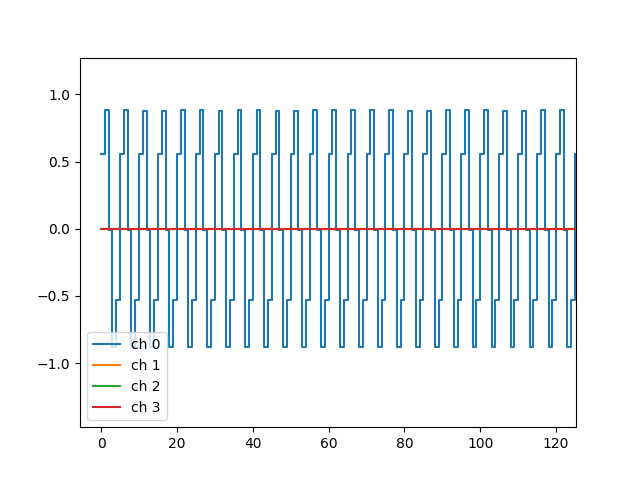

In [287]:
close('all')
for i in range(4):
#     dat = array(r.big_read(0x10000000 + i * 0x01000000, 0x1000))
#     dat = twos_comps(dat >> 2, 14)
    dat = getSamples(r, i, 0x1000)
    plot(dat, label='ch ' + str(i), drawstyle='steps-post')
legend()

In [283]:
r.regs.ctrl_bus_errors.read()

0

# Vector volt-meter

In [45]:
ftw = int(29.4e6 / 117.6e6 * 2**32)
r.regs.vvm_ddc_ftw.write(ftw)
r.regs.vvm_ddc_deci.write(1000)
print('f_sample', r.regs.lvds_f_sample_value.read())
print('ddc_deci', r.regs.vvm_ddc_deci.read())
print('ddc_ftw', hex(r.regs.vvm_ddc_ftw.read()))

f_sample 117600595
ddc_deci 1000
ddc_ftw 0x40000000


In [52]:
print("Magnitude")
for i in range(4):
    print(getattr(r.regs, "vvm_mag{}".format(i)).read() / (1 << 23))
print("\nPhase")
for i in range(4):
    print(getInt32(getattr(r.regs, "vvm_phase{}".format(i)).read()) / (1 << 31))

Magnitude
0.0004709959030151367
0.0005244016647338867
0.0005433559417724609
0.0005850791931152344

Phase
-0.38046344369649887
0.017182630952447653
-0.013416060246527195
-0.01616238383576274


# Demonstrate bit - mapping ...
of serdes lane bits to ADC sample words

In [282]:
N_CHANNELS = 4
S = 8
D = N_CHANNELS * 2 + 1
data_outs = [arange(i * S, (i + 1) * S) for i in range(D)]
for i, d in enumerate(data_outs):
    print("lane", i, "bit", d)
print()
for i in range(N_CHANNELS):
    print("channel", i, myzip(data_outs[2 * i + 1], data_outs[2 * i])[2:])

lane 0 bit [0 1 2 3 4 5 6 7]
lane 1 bit [ 8  9 10 11 12 13 14 15]
lane 2 bit [16 17 18 19 20 21 22 23]
lane 3 bit [24 25 26 27 28 29 30 31]
lane 4 bit [32 33 34 35 36 37 38 39]
lane 5 bit [40 41 42 43 44 45 46 47]
lane 6 bit [48 49 50 51 52 53 54 55]
lane 7 bit [56 57 58 59 60 61 62 63]
lane 8 bit [64 65 66 67 68 69 70 71]

channel 0 [9, 1, 10, 2, 11, 3, 12, 4, 13, 5, 14, 6, 15, 7]
channel 1 [25, 17, 26, 18, 27, 19, 28, 20, 29, 21, 30, 22, 31, 23]
channel 2 [41, 33, 42, 34, 43, 35, 44, 36, 45, 37, 46, 38, 47, 39]
channel 3 [57, 49, 58, 50, 59, 51, 60, 52, 61, 53, 62, 54, 63, 55]
